# PS-S3E13 Vector Borne Disease Classifiation EDA and Baseline Model

* Added orig data 4/23/23


# Imports

In [1]:
import os
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 70)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# MAP@k metric

* Thanks to [this](https://www.kaggle.com/code/wlifferth/generating-map-k-predictions/notebook) notebook for the MAP@k implementation



In [2]:
# Sourced from the ml_metrics package at https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
import numpy as np

def apk(actual, predicted, k=3):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

# Load .csv files

In [3]:
root_dir = '/kaggle/input/playground-series-s3e13'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (707, 66)


,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


Test Data Shape: (303, 65)


,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,708,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,709,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,710,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,711,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Sample Submission Shape: (303, 2)


,id,prognosis
0,707,Dengue Zika Japanese_encephalitis
1,708,Dengue Zika Japanese_encephalitis
2,709,Dengue Zika Japanese_encephalitis
3,710,Dengue Zika Japanese_encephalitis
4,711,Dengue Zika Japanese_encephalitis


### Takeaways
* There are 64 feature columns + id and the target is prognosis
* All columns are binary (verify)
* This is a pretty small dataset.  
    * train has 707 records
    * test has 303 records

## Load Orig Data

In [4]:
orig = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv')
orig.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


In [5]:
train = pd.concat([train,orig],ignore_index=True)

In [6]:
train.shape

(1414, 66)

## Top Level Statistics

In [7]:
# todo: plot the mean and std for train and test to compare, then with orig also
display(train.describe())
display(test.describe())

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
count,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000,1414.000000
mean,353.000000,0.503536,0.449788,0.459689,0.487977,0.517680,0.449788,0.441301,0.487977,0.390382,0.393211,0.381895,0.373409,0.360679,0.339463,0.379066,0.394625,0.359264,0.377652,0.322489,0.323904,0.335219,0.332390,0.367751,0.411598,0.390382,0.380481,0.336634,0.353607,0.398868,0.360679,0.308345,0.376238,0.448373,0.449788,0.404526,0.451202,0.480905,0.482320,0.438472,0.374823,0.272984,0.214993,0.240453,0.226308,0.223479,0.253182,0.219236,0.227723,0.213579,0.131542,0.195191,0.176803,0.202263,0.171146,0.148515,0.072136,0.097595,0.079208,0.084866,0.154173,0.144272,0.137199,0.032532,0.031117
std,204.165323,0.500164,0.497648,0.498549,0.500032,0.499864,0.497648,0.496718,0.500032,0.488008,0.488636,0.486023,0.483880,0.480367,0.473694,0.485326,0.488943,0.479955,0.484971,0.467594,0.468129,0.472234,0.471237,0.482364,0.492297,0.488008,0.485677,0.472726,0.478258,0.489839,0.480367,0.461973,0.484612,0.497504,0.497648,0.490974,0.497789,0.499812,0.499864,0.496375,0.484248,0.445651,0.410963,0.427510,0.418589,0.416724,0.434988,0.413875,0.419511,0.409978,0.338111,0.396488,0.381637,0.401829,0.376769,0.355735,0.258804,0.296872,0.270159,0.278780,0.361242,0.351489,0.344179,0.177471,0.173696
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,176.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,353.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.00000,303.000000,303.000000,303.000000,303.000000,303.00000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,858.000000,0.577558,0.462046,0.458746,0.504950,0.531353,0.541254,0.488449,0.448845,0.458746,0.415842,0.366337,0.415842,0.396040,0.339934,0.369637,0.422442,0.313531,0.379538,0.293729,0.386139,0.336634,0.30033,0.399340,0.455446,0.382838,0.386139,0.30033,0.353135,0.356436,0.363036,0.323432,0.353135,0.445545,0.478548,0.445545,0.471947,0.475248,0.501650,0.448845,0.389439,0.313531,0.217822,0.227723,0.214521,0.234323,0.227723,0.231023,0.224422,0.198020,0.138614,0.204620,0.181518,0.221122,0.207921,0.145215,0.092409,0.099010,0.102310,0.118812,0.165017,0.128713,0.122112,0.052805,0.033003
std,87.612784,0.494765,0.499382,0.499120,0.500803,0.499842,0.499120,0.500693,0.498199,0.499120,0.493682,0.482600,0.493682,0.489882,0.474470,0.483505,0.494765,0.464696,0.486075,0.456223,0.487668,0.473340,0.45916,0.490573,0.498835,0.486883,0.487668,0.45916,0.478735,0.479738,0.481671,0.468560,0.478735,0.497848,0.500366,0.497848,0.500038,0.500213,0.500824,0.498199,0.488430,0.464696,0.413448,0.420056,0.411169,0.424276,0.420056,0.422184,0.417892,0.399166,0.346115,0.404091,0.386085,0.415689,0.406491,0.352900,0.290082,0.299169,0.303557,0.324102,0.371809,0.335436,0.327957,0.224015,0.178941
min,707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,782.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,858.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

### Takeaways
* Right now means looks like they are all around .5.
* Std looks like they are all around .5 too
* Should do a visualization of this

In [8]:
# display(train.info())
# display(test.info())

### Takeaways
* There are no missing data points in the test or training sets so no imputation required
* All columns are float 64
    * Better to convert to int8?
    * or bool (?)

# Should look at differences in train and orig

## Plot Probability of Positive Prognosis given Symptom

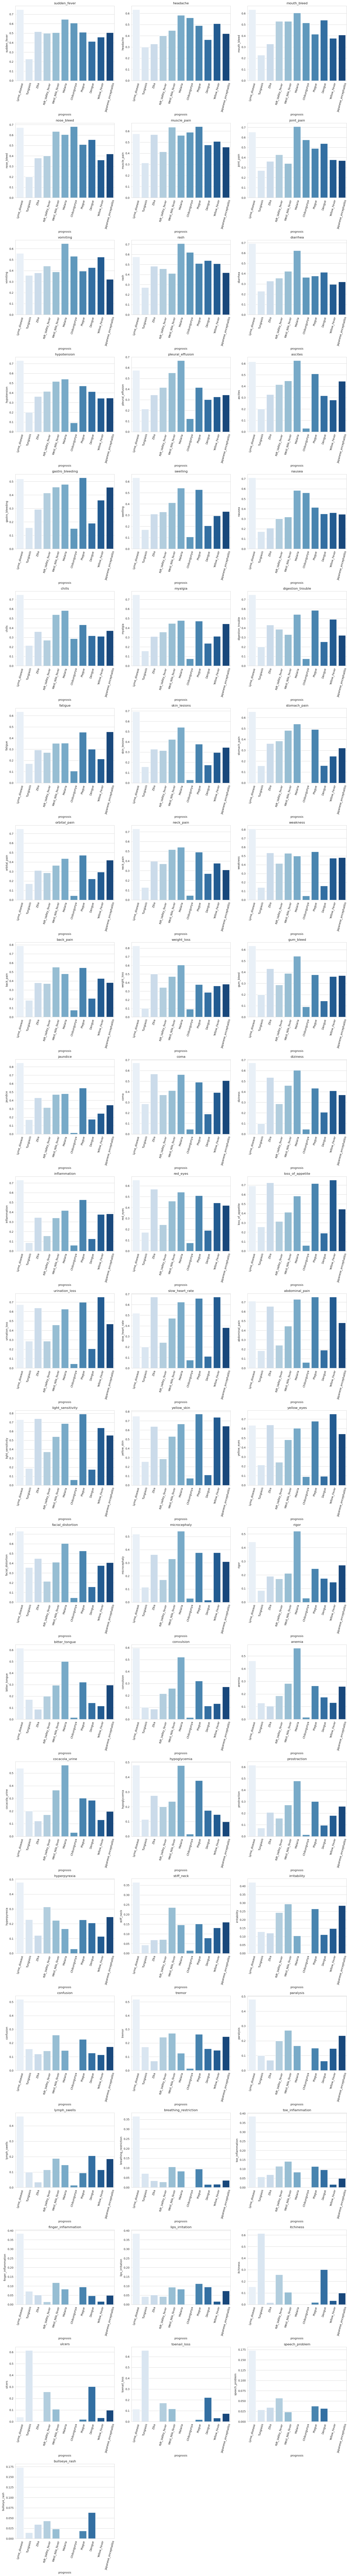

In [9]:
features = [col for col in train.columns if train[col].dtype=='float']
rows = int(np.ceil(len(features)/3)) 
plt.figure(figsize=(18,6*rows),tight_layout=True) 
for i,col in enumerate(features): 
    plt.subplot(rows,3,i+1) 
    sns.barplot(x=train.prognosis, y=train[col],palette='Blues',ci=None)
    plt.xticks(rotation=75)
    plt.title(col)


In [10]:
train.groupby('prognosis').mean()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
prognosis,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Chikungunya,349.121212,0.606061,0.560606,0.515152,0.681818,0.590909,0.575758,0.530303,0.621212,0.363636,0.090909,0.121212,0.030303,0.151515,0.106061,0.560606,0.287879,0.075758,0.075758,0.106061,0.030303,0.000000,0.045455,0.045455,0.045455,0.075758,0.090909,0.090909,0.015152,0.045455,0.045455,0.060606,0.075758,0.060606,0.045455,0.075758,0.060606,0.060606,0.075758,0.090909,0.045455,0.030303,0.030303,0.015152,0.015152,0.015152,0.030303,0.015152,0.015152,0.030303,0.015152,0.000000,0.000000,0.015152,0.000000,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Dengue,353.285714,0.412698,0.365079,0.539683,0.555556,0.476190,0.539683,0.428571,0.539683,0.412698,0.412698,0.301587,0.317460,0.190476,0.206349,0.349206,0.317460,0.238095,0.253968,0.301587,0.174603,0.158730,0.222222,0.269841,0.158730,0.206349,0.285714,0.142857,0.174603,0.190476,0.206349,0.126984,0.190476,0.190476,0.206349,0.111111,0.190476,0.174603,0.111111,0.095238,0.158730,0.015873,0.174603,0.142857,0.111111,0.174603,0.285714,0.174603,0.095238,0.206349,0.079365,0.111111,0.126984,0.158730,0.063492,0.206349,0.015873,0.095238,0.047619,0.095238,0.301587,0.301587,0.222222,0.031746,0.063492
Japanese_encephalitis,339.296296,0.506173,0.419753,0.407407,0.419753,0.456790,0.370370,0.320988,0.419753,0.320988,0.345679,0.345679,0.444444,0.456790,0.333333,0.345679,0.370370,0.444444,0.320988,0.456790,0.345679,0.320988,0.419753,0.308642,0.481481,0.382716,0.382716,0.370370,0.345679,0.506173,0.370370,0.382716,0.419753,0.444444,0.469136,0.382716,0.481481,0.555556,0.641975,0.543210,0.407407,0.308642,0.271605,0.296296,0.271605,0.259259,0.197531,0.098765,0.259259,0.246914,0.160494,0.283951,0.172840,0.246914,0.234568,0.185185,0.037037,0.049383,0.049383,0.074074,0.098765,0.098765,0.074074,0.000000,0.000000
Lyme_disease,344.846154,0.750000,0.634615,0.634615,0.673077,0.576923,0.653846,0.557692,0.576923,0.692308,0.730769,0.576923,0.615385,0.519231,0.634615,0.711538,0.750000,0.750000,0.750000,0.634615,0.692308,0.653846,0.750000,0.730769,0.807692,0.788462,0.826923,0.634615,0.846154,0.673077,0.673077,0.730769,0.653846,0.692308,0.673077,0.519231,0.711538,0.730769,0.750000,0.634615,0.730769,0.519231,0.442308,0.615385,0.596154,0.461538,0.538462,0.480769,0.615385,0.480769,0.365385,0.423077,0.519231,0.519231,0.480769,0.461538,0.365385,0.384615,0.384615,0.384615,0.153846,0.038462,0.115385,0.173077,0.173077
Malaria,342.604167,0.645833,0.583333,0.604167,0.604167,0.562500,0.708333,0.645833,0.708333,0.625000,0.541667,0.666667,0.625000,0.479167,0.541667,0.583333,0.583333,0.479167,0.541667,0.354167,0.541667,0.541667,0.437500,0.541667,0.500000,0.479167,0.604167,0.541667,0.479167,0.562500,0.604167,0.416667,0.541667,0.583333,0.625000,0.625000,0.729167,0.687500,0.666667,0.604167,0.604167,0.541667,0.520833,0.500000,0.520833,0.562500,0.562500,0.479167,0.479167,0.166667,0.145833,0.104167,0.145833,0.125000,0.166667,0.145833,0.083333,0.083333,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000
Plague,363.150943,0.509434,0.490566,0.415094,0.509434,0.641509,0.490566,0.396226,0.509434,0.377358,0.471698,0.415094,0.509434,0.528302,0.528302,0.415094,0.433962,

## Target Feature

In [11]:
print(f'There are {train.prognosis.nunique()} unique target values')

There are 11 unique target values


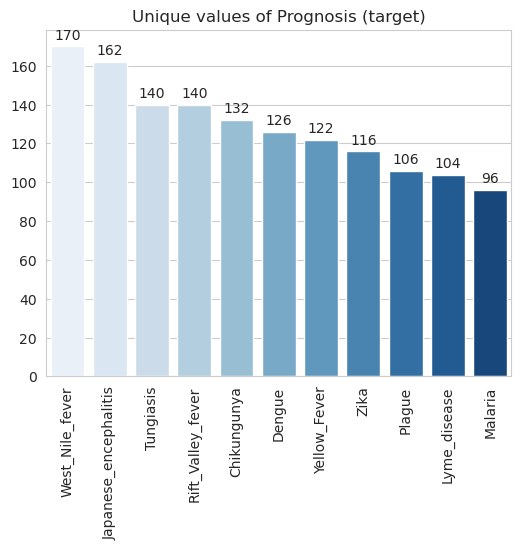

In [12]:
prog_cts = train.prognosis.value_counts()
#train['prognosis'].value_counts(sort=False).plot.bar(rot=90)

plt.figure(figsize=(6,4.5))
plot = sns.barplot(x=prog_cts.index,y=prog_cts.values, palette='Blues')
plt.xticks(rotation=90)
for bar in plot.patches:
    plot.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Unique values of Prognosis (target)');

# Encode Target

In [13]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
train['prognosis'] = enc.fit_transform(train[['prognosis']])
y = train.prognosis

# Feature Engineering

## Add sum of symptoms feature

In [14]:
train = train.drop('id',axis=1)
train = train.drop('prognosis',axis=1)  # combine with above
test = test.drop('id',axis=1)
train.head(2)

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
train['sum_sympt'] = train.sum(axis=1)
test['sum_sympt'] = test.sum(axis=1)

features = [feat for feat in test.columns]  # add to features

In [16]:
train.head(2)

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,sum_sympt
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [17]:
# t = enc.inverse_transform(y.values.reshape(-1,1)).squeeze()
# train['prognosis'] = t
# train.head()

In [18]:
# train.groupby(train.prognosis).sum_sympt.mean()
# plt.figure()
# sns.barplot(x=train.prog2, y=train.sum_sympt,palette='Blues',ci=None)
# plt.xticks(rotation=90);

## Make a plot as an image and use image processing


In [19]:
# out_path = '/kaggle/working/png_files/'
# if not os.path.exists(out_path):
#     os.mkdir(out_path)
# sns.set_style('white')

# for row in tqdm(range(len(train))):
#     #row = 0
#     data = train.iloc[row].values[0:64]
#     x = range(64)
#     data.reshape(64,1)
#     plt.bar(x,data)
#     plt.axis('off')
#     plt.savefig(f'{out_path}row_{row}.png')

# Model Training
* What is the best model(s) to use for this type of problem with all binary data and multiclass output?  
* Models to try
    * Logistic Regression
    * SVM
    * Decision Tree, Random Forest
    * Boosted Trees
    * others?

## ML Imports

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

seed = 12
folds = 5
repeats = 12

## CV Function

In [21]:
# if continuous, change predict_proba to predict
def run_cv_and_predict(train, test, y,features, model, seed,verbose=True):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = [] #np.zeros((test.shape[0], folds),dtype='str')   # need list for categorical (strings)

    # setup folding strategy
    #skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)
    skf = RepeatedStratifiedKFold(n_splits=folds,n_repeats=repeats,random_state=seed)
    # Use KFold if target is continuous
    #skf = KFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)  # gives 11 probabilities for each row
        #print(f'fold preds shape: {fold_preds.shape}')  # 142 rows by 11
        sorted_fold_pred_ids = np.argsort(-fold_preds,axis=1)
        #print(f'sorted fold preds shape: {sorted_fold_pred_ids.shape}')  # 142 rows by 11
        top_3_pred_ids = sorted_fold_pred_ids[:,:3]
        #print(f'top3 preds: {top_3_pred_ids.shape}')
        
        # compute scores
        fold_score = mapk(y.values.reshape(-1, 1), top_3_pred_ids)
        oof[val_idx] = fold_score
        fold_scores.append(fold_score)
        if verbose:
            print(f'map@k score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict_proba(test[features])  # gives 11 probabilities for each row
        sorted_test_pred_ids = np.argsort(-test_preds,axis=1)
        top_3_tp_ids = sorted_test_pred_ids[:,:3]   
        
        # re-encode labels
        orig_shape = top_3_tp_ids.shape
        top_3_test_preds = enc.inverse_transform(top_3_tp_ids.reshape(-1,1))
        top_3_test_preds = top_3_test_preds.reshape(orig_shape)

        preds.append(top_3_test_preds)
        
        cur_fold +=1
        

    # Print mean fold and oof score 
    oof_score = np.mean(oof) 
    print(f'MAPk average score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {np.mean(oof):.5f}')

    return (preds,fold_scores,oof_score,oof)

# Mode and Format Output Function

In [22]:
# take mode of each row and return highest count
# more advanced to try: keep track of highest and second highest in the wrong preds to add to second rank

# function for computing mode
def mode(arr):
        if arr==[]:
            return None
        else:
            return max(set(arr), key=arr.count)

# get mode of fold preds and format to string that can be added to sample submission.
def format_preds(model_preds):
    preds = []
    row = 1
    for row in range(len(test)):
        fold_preds1, fold_preds2, fold_preds3 = [],[],[]
        for fold in range(folds):
            a1 = str(model_preds[fold][row][0])
            a2 = str(model_preds[fold][row][1])
            a3 = str(model_preds[fold][row][2])
            fold_preds1.append(a1)
            fold_preds2.append(a2)
            fold_preds3.append(a3)
        preds.append(f'{mode(fold_preds1)} {mode(fold_preds2)} {mode(fold_preds3)}')

    #print(f'{mode(fold_preds1)} {mode(fold_preds2)} {mode(fold_preds3)}')
    return preds


## Model 1 - Logistic Regression

In [23]:
model = LogisticRegression()
preds_lr,scores_lr,oof_score_lr, oof_lr = run_cv_and_predict(train,test,y,features, model, seed,verbose=False)

# default, 5 folds, 
# MAPk average score: 0.14974, Stdev: 0.02163, OOF score: 0.14969, lb = .33443
# 5 x 12,.15117
# 4 x 12: .15308
# 6 x 12, .15319

# add orig data,
# 5 x 12: MAPk average score: 0.15989, Stdev: 0.01736, OOF score: 0.14734, lb = .34768
# add sum feat, MAPk average score: 0.16029, Stdev: 0.01718, OOF score: 0.15182

MAPk average score: 0.16152, Stdev: 0.01681, OOF score: 0.15335


## Model 2: Decision Tree

In [24]:
# from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier(max_depth=5,random_state=seed)
# preds_dt,scores_dt,oof_score_dt, oof_dt = run_cv_and_predict(train,test,y,features, model, seed,verbose=False)

# 21 depth: MAPk average score: 0.10915, Stdev: 0.01513, OOF score: 0.10915, but lb = .23068 (bad)
# 4 max depth: MAPk average score: 0.15000, Stdev: 0.02175, OOF score: 0.14993, lb = .32119

# 5 folds is the highest, cv = .15798
# 4 x 12 = .14580
# 5 x 12 = .15039
# 6 x 12 = .14909

# add orig data
# MAPk average score: 0.16595, Stdev: 0.01462, OOF score: 0.16537, lb = 

# add sum feat
#MAPk average score: 0.17328, Stdev: 0.01548, OOF score: 0.17574


## Model 3: Random Forest

In [25]:
# from sklearn.ensemble import RandomForestClassifier

# # # data = []
# # # for n_est in range(50,3000,50):#[50,100,200,300,500,700,1000,2000]:

# model = RandomForestClassifier(random_state=seed,n_estimators=250)
# preds_rf,scores_rf,oof_score_rf, oof_rf = run_cv_and_predict(train,test,y,features, model, seed,verbose=False)

#     scores_rf = np.mean(scores_rf)
#     data.append([n_est,scores_rf])

# data = np.array(data)
# plt.plot(data[:,0],data[:,1])

# default: MAPk average score: 0.16436, Stdev: 0.03168, OOF score: 0.16431, lb = .38962 (higher than lr)
# Tuning 1 (n_est).  best is 200, 
# MAPk average score: 0.17264, Stdev: 0.03732, OOF score: 0.17256, lb = .35761  (lower lb)

# n_est = 100, rskf = .15847 5 x 10
# n_est = 200, rskf = .15948 5 x 10
# n_est = 200, 8 x 8, rskf = .15521
# 4 x 12, 200, .15662
# 5 x 12, 100 - .15751, lb = .39624, repeat, .39293, .37748, 
# 6 x 12, 100 = .15420
# 5 x 12, 200 = .15754, lb = .36865
# 5 x 12, 300 = .15687
# 5x12, 500 = .15657

# 5x12 add orig data:
# MAPk average score: 0.16471, Stdev: 0.01669, OOF score: 0.16172

# add sum feat
# MAPk average score: 0.16631, Stdev: 0.01557, OOF score: 0.16726, lb = .38520

# estimators from 100 to 150
# MAPk average score: 0.16759, Stdev: 0.01472, OOF score: 0.16678, lb = .35320

# estimators = 250
# MAPk average score: 0.16731, Stdev: 0.01520, OOF score: 0.16360, lb = 

In [26]:
# model.get_params()

## Model 4: SVM

In [27]:
from sklearn.svm import SVC, LinearSVC

# # for k in ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']:

model = SVC(kernel='sigmoid',random_state = 12,probability=True)
preds_svm,scores_svm,oof_score_svm, oof_svm = run_cv_and_predict(train,test,y,features, model, seed,verbose=False)
    
    
# rbf solver else default:
# MAPk average score: 0.17499, Stdev: 0.03397, OOF score: 0.17492,lb = .36754
# 4 x 12: .15805

# add orig data:
# MAPk average score: 0.16402, Stdev: 0.01464, OOF score: 0.15971

# kernel optimization
# kernel = linear: MAPk average score: 0.16669, Stdev: 0.01541, OOF score: 0.15865
# kernel = poly: MAPk average score: 0.16522, Stdev: 0.01628, OOF score: 0.15842
# kernel = rbf: MAPk average score: 0.16402, Stdev: 0.01464, OOF score: 0.15971
# kernel = sigmoid: MAPk average score: 0.17842, Stdev: 0.01459, OOF score: 0.17468

# loks like sigmoid wins: cv = .17842 (high), but lb = .29801
# degree doesn't matter at all.
# add sum_symp: .18216

MAPk average score: 0.17698, Stdev: 0.01794, OOF score: 0.17374


In [28]:
#model.get_params()

## Model 4: KNN

In [29]:
# from sklearn.neighbors import KNeighborsClassifier

# model = KNeighborsClassifier(n_neighbors=4, leaf_size=25)
# preds_knn,scores_knn,oof_score_knn, oof_knn = run_cv_and_predict(train,test,y,features, model, seed)

#knn with one optimization, n_neighbors = 4, leaf_size=25 (but all same)
# MAPk average score: 0.14874, Stdev: 0.01810, OOF score: 0.14875, lb = 
# 4 x 12: .12585 (?)
# 6 x 12: .13238

# add orig data 5x12 : .13891


### KNN Tuning Plot

In [30]:
# import plotly.express as px

# fig = px.scatter_3d(x=data[:,0], y=data[:,1], z=data[:,2])  # scatter of 3 cols of df
# fig.update_traces(marker={'size': 3})
# fig.show(renderer='notebook')

#plt.([data[:,0],data[:,1],data[:,2]])

In [31]:
# model.get_params()

## Model 5: Catboost

In [32]:
# from catboost import CatBoostClassifier

# model = CatBoostClassifier(verbose=False,random_state=seed)
# preds_cat,scores_cat,oof_score_cat, oof_cat = run_cv_and_predict(train,test,y,features, model, seed, verbose=False)

# default:
# MAPk average score: 0.15586, Stdev: 0.02657, OOF score: 0.15582, lb = 
# 4 x 12, .15560
# 6 x 12, .14983

# add orig data, 5x12, lb = .37196
# add sum featues, 5x12, 

## Model 6: XGBoost

In [33]:
# xgb_params = {'objective': 'multi:softprob',
#               'eval_metric': 'mlogloss',
#               'num_class': 11,
#               'learning_rate': 0.01,
#               'n_estimators': 500,
#               'max_depth': 5,
#               #'early_stopping_rounds': 200,
#               'subsample': 0.7,
#               'colsample_bytree': 0.6,
#               'n_jobs': -1,
#               'verbosity': 0,
#               'random_state': seed}

# from xgboost import XGBClassifier

# model = XGBClassifier(**xgb_params)
# preds_xgb,scores_xgb,oof_score_xgb, oof_xgb = run_cv_and_predict(train,test,y,features, model, seed, verbose=False)

# params1, 5x12, with orig:
# MAPk average score: 0.16670, Stdev: 0.01703, OOF score: 0.15311, lb = .38300

# add sum_sympt feat
# MAPk average score: 0.16855, Stdev: 0.01819, OOF score: 0.16007,

# MAPk average score: 0.16751, Stdev: 0.01671, OOF score: 0.15653

# 500 est, 5 max depth, .01 lr:
# MAPk average score: 0.16819, Stdev: 0.01671, OOF score: 0.15818, lb = 

In [34]:
# preds_xgb

In [35]:
train.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,sum_sympt
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,51.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,6.0


## XGB CV Method 2

In [36]:
# def selecting_top_3(arr): 
#     n = arr.shape[0]
#     out = np.zeros((n, 3))
#     for i in range(0, n):
#         out[i, ] = arr[i,].argsort()[::-1][:3]
#     return out.astype('int32')

In [37]:
# X = train
# #le = LabelEncoder()
# #le.fit(train['prognosis'])
# #Y = pd.DataFrame(le.transform(train['prognosis']))
# Y = y

# preds, cv_scores = [],[]

# skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
# for train_ix, test_ix in skf.split(X, Y):
        
#     X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
#     Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
#     XGB_md = XGBClassifier(objective = 'multi:softprob',
#                            #tree_method = 'gpu_hist',
#                            colsample_bytree = 0.6,  
#                            gamma = 0.8,  
#                            learning_rate = 0.01, 
#                            max_depth = 5,
#                            min_child_weight = 5, 
#                            n_estimators = 500, 
#                            subsample = 0.7).fit(X_train, Y_train)

#     XGB_pred_1 = selecting_top_3(XGB_md.predict_proba(X_test))
#     cv_scores.append(mapk(Y_test.values.reshape(-1, 1), XGB_pred_1, k = 3))
    
#     preds.append(XGB_md.predict_proba(test))
    
# cv_score = np.mean(cv_scores)
# print('The oof map3 score of the XGBoost model is', cv_score)

In [38]:
# len(preds[0]) # 5 x 303, 3 folds 

# Select model for submission

In [39]:
preds_final = format_preds(preds_svm)  # swap model here
preds_final[:5]

['Chikungunya Tungiasis Dengue',
 'Japanese_encephalitis West_Nile_fever West_Nile_fever',
 'Japanese_encephalitis West_Nile_fever Rift_Valley_fever',
 'Japanese_encephalitis Rift_Valley_fever West_Nile_fever',
 'Japanese_encephalitis West_Nile_fever West_Nile_fever']

# Submission

* Looks like there are three disease types per row
* Start with random

In [40]:
ss.prognosis = preds_final
ss.head()

,id,prognosis
0,707,Chikungunya Tungiasis Dengue
1,708,Japanese_encephalitis West_Nile_fever West_Nil...
2,709,Japanese_encephalitis West_Nile_fever Rift_Val...
3,710,Japanese_encephalitis Rift_Valley_fever West_N...
4,711,Japanese_encephalitis West_Nile_fever West_Nil...


In [41]:
ss.to_csv('submission.csv',index=False)